<font size="1"> *This notebook is best viewed in jupyter lab/notebook. You may also choose to use Google Colab but some parts of the images/colouring will not be rendered properly.</font>

<div class="alert alert-block alert-warning">

# <p style="text-align: center;">Lab 4 (Weeks 8,9): Convolutional Neural Networks (CNNs)</p>
## <p style="text-align: center;">Notebook I: Basics</p>


<img src="https://miro.medium.com/v2/resize:fit:592/1*V6Y8FF2qfw_ztNbs1AHXNg.png" width="800" height="400" />

<!-- ![linear-vs-logistic-regression--medium](https://miro.medium.com/max/1400/1*dm6ZaX5fuSmuVvM4Ds-vcg.jpeg) -->

Welcome to the fourth and <b>final</b> lab! As usual, this lab will span over two weeks.
            
In this Lab, you will find four tasks distributed across two Jupyter Notebooks: *Lab4_Basics_student.ipynb* and *Lab4_Applications_student.ipynb*. The first two tasks guide you to train a basic CNN using pytorch lightning. In the last task, you will apply the knowledge you gained to solve a practical problem.
    
- <b>Task 1:</b> Design a CNN and train to classify STL-10 images
- <b>Task 2:</b> Analyse the results on the STL-10 test images
- <b>Task 3:</b> Design and train a CNN by yourself on the FER-4 dataset and analyse results
      
Each task will contain code to complete, and a worded question, so ensure you complete both before submitting. Feel free to add your own additional comments.
    
After completion, You need to submit both Jupyter Notebooks (.ipynb files) to Moodle. Make sure all the outputs are visible before submitting.
    
Good luck with the final Lab! Submit it before the <b>deadline</b> to enjoy full marks.

__Submission details:__
- __Make sure you have run all your cells from top to bottom (you can click _Kernel_ and _Restart Kernel and Run All Cells_).__ </br>
- __Submit the Jupyter Notebooks (Lab4_Basics.ipynb_) and (Lab4_Applications.ipynb_).__
- __Outputs must be visible upon submission. We will also be re-running your code__

<img src="https://miro.medium.com/v2/resize:fit:592/1*V6Y8FF2qfw_ztNbs1AHXNg.png" width="1000" height="500" />

<div class="alert alert-block alert-warning">

Welcome to the fourth and <b>final</b> lab! As usual, this lab will span over two weeks.
            
In this Lab, you will find four tasks distributed across two Jupyter Notebooks: *Lab4_Basics_student.ipynb* and *Lab4_Applications_student.ipynb*. The first two tasks guide you to train a basic CNN using pytorch lightning. In the last task, you will apply the knowledge you gained to solve a practical problem.
    
- <b>Task 1:</b> Design a CNN and train to classify STL-10 images
- <b>Task 2:</b> Analyse the results on the STL-10 test images
- <b>Task 3:</b> Design and train a CNN by yourself on the FER-4 dataset and analyse results
      
Each task will contain code to complete, and a worded question, so ensure you complete both before submitting. Feel free to add your own additional comments.
    
After completion, You need to submit both Jupyter Notebooks (.ipynb files) to Moodle. Make sure all the outputs are visible before submitting.
    
Good luck with the final Lab! Submit it before the <b>deadline</b> to enjoy full marks.

<div class="alert alert-block alert-info">
    
## Learning Objective
    
In the previous lab, you focused on classification tasks using MLPs. In this lab, you will focus on image classification using CNNs. There are differences in how MLPs and CNNs operates. You will also notice that many of the steps are identical, except for some small differences such as your class defining your network, and the way you pre-process and post-process the data. This is the beauty of PyTorch and more generally, modular differentiable programming.

<b>Enter you student details below</b>

- <b>Student Name:</b> Daniel Kazakevich
- <b>Student ID:</b> 33155542

<div class="alert alert-block alert-danger">

## Table of Contents
    
* [Libraries](#Libraries)

    
* [Task 1: Design a CNN and train to classify STL-10 images](#task_1)  
    * [1.1 Create Pytorch datasets and dataloaders for STL-10](#t1_1)
    * [1.2 Visualize the dataset](#t1_2)
    * [1.3 Design the CNN and Lightning Modules](#t1_3)  
    * [1.4 Train and Evaluate the CNN](#t1_4)
    * [1.5 Visualize training and validation loss/accuracy](#t1_5)   
    * [Discussion Questions](#t1_6)
    
    
* [Task 2: Analyse the results on the STL-10 test images](#task_2)  
    * [2.1 Visualize predictions](#t2_1)
    * [2.2 Visualize Top Classified/Misclassified](#t2_2)
    * [2.3 Confusion Matrix](#t2_3)
    * [2.4 Visualize Feature maps](#t2_4)
    * [2.5 Visualize Saliency maps](#t2_5)
    * [Discussion Questions](#t2_6)

<div class="alert alert-block alert-warning">

# Libraries

In this lab, you will use several pytorch and lightning libraries along with several other basic python libraries. All the libraries that you need are given below.

## Note for lab 4!
We have migrated lab 4 to "lightning" instead of "pytorch_lightning". The only difference is the way you import the lightning modules. All functionalities are identical.

In [7]:
import os
import random
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torch.nn.functional import log_softmax, softmax
import torchvision
import torchvision.transforms.functional as F
from torchvision import transforms
import torchmetrics
from torchmetrics import ConfusionMatrix
from torchsummary import summary

from IPython.display import display

In [8]:
# Pytorch lightning is a wrapper for pytorch that makes it easier to train models.
# We will use lightning instead of pytorch-lightning. The functionality is the same.
# But the import structure for lightning is slightly different
# This is because lightning contains other lightning-based packages and pytorch-lightning is one of them.

import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import Callback, ModelCheckpoint, EarlyStopping
from pytorch_lightning.callbacks.progress import TQDMProgressBar, RichProgressBar
from pytorch_lightning.callbacks.progress.rich_progress import RichProgressBarTheme

# Setting seeds for reproducibility
pl.seed_everything(4179)
random.seed(4179)
np.random.seed(4179)

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

INFO:lightning_fabric.utilities.seed:Seed set to 4179


<div class="alert alert-block alert-warning">

# STL-10 dataset <a class="anchor" id="python-basics"></a>
    
For all the work in this notebook, you will be using the [STL-10 dataset](https://cs.stanford.edu/~acoates/stl10/).
    
<img src="https://cs.stanford.edu/~acoates/stl10/images.png" width="500" height="500" />
    
The STL-10 dataset is a widely used benchmark in machine learning, containing images of 10 distinct object classes: airplane, bird, car, cat, deer, dog, horse, monkey, ship', truck. Each image is of size 96x96 pixels, enabling efficient processing. The train set contains 5000 images whereas the validation and test set contains 8000 images in total. STL-10 serves as a challenging testbed for image classification algorithms, encouraging the development of robust and accurate models.

<div class="alert alert-block alert-info">

# Task 1 - Design a CNN and train to classify STL-10 images <a class="anchor" id="task_1"></a>
        
In Task 1, you will design a CNN for image classification task and train it on the STL-10 dataset. You will use PyTorch's inbuilt datasets class, and Lightning's module class to construct a CNN in order to perform training on the STL-10 dataset.

<div class="alert alert-block alert-info">

## 1.1 Create Pytorch datasets and dataloaders for STL-10 <a class="anchor" id="t1_1"></a>
     
The original STL-10 dataset contains 5000 train images and 8000 test images. In this task, we will take out 1000 images from the test set as validation images.

In [9]:
class_names = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']
num_classes = len(class_names)
print(f'Number of classes: {num_classes}')

Number of classes: 10


### Transforms & Data Augmentation

In this lab, we are also introducing transforms to the image datasets. This concept is covered in the workshops, and [here](https://pytorch.org/vision/stable/transforms.html) is the pyTorch documentaion about transforms.

We will give you some guidance on how to implement the transforms in this lab  but keep in mind that this concept and implementation will be critical for the assignment later on. The transforms we will use are mainly ("ToTensor()" and "Normalize()") which we have used in the workshop. Now in addition to the usual transforms, we will be adding __data augmentation__ as well. The ones we have included are:

- RandomHorizontalFlip()
- RandomRotation()

Now, what is **data augmentation**? Data augmentation in deep learning refers to the process of artificially diversifying a dataset by applying various transformations and modifications to the existing training examples. The objective of data augmentation is to enhance the model's generalization capability and robustness by exposing it to a wider range of variations and scenarios that might be encountered during real-world inference. These transformations can include rotations, flips, translations, changes in lighting and contrast, cropping, and more, depending on the nature of the data. By introducing this augmented data during training, the model becomes better equipped to handle novel and previously unseen examples, effectively reducing overfitting and improving its ability to extract meaningful features from noisy or imperfect inputs. Data augmentation has become a fundamental technique in deep learning, contributing significantly to the improved performance of neural networks across various tasks, from image and speech recognition to natural language processing.

Now, why do we only apply augmentation to the training set? Data augmentation is specifically applied to the training set and not the test set because the purpose of data augmentation is to introduce diversity and variation into the training examples, helping the model to generalize better to real-world scenarios. The test set serves as an unbiased evaluation of the model's performance on unseen data. If data augmentation were applied to the test set, it could lead to overly optimistic performance estimates, as the model would have already seen similar augmented examples during training, potentially inflating its apparent accuracy.

In [10]:
# Define a series of transformations to be applied to training data

# hint: Use Compose function that allows you to combine multiple image transformations into a sequential pipeline.
#       Each transformation will be applied in the order they appear within the list.
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(random.random()), # Randomly flip images horizontally (left to right)
    transforms.RandomRotation(10), # Apply a random rotation up to 10 degrees to each image
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(0.5, 0.5),     # Normalize pixel values to have a mean and standard deviation of 0.5
])

# Define a series of image transformations to be applied to validation and test data
val_test_transforms = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(0.5,0.6) # Normalize pixel values to have a mean and standard deviation of 0.5
])

### Datasets

Torchvision provides many built-in datasets in the `torchvision.datasets` module, as well as utility classes for building your own datasets.

All datasets are subclasses of `torch.utils.data.Dataset` i.e, they have **\__getitem\__** and **\__len\__** methods implemented. Hence, they can all be passed to a `torch.utils.data.DataLoader` which can load multiple samples in parallel using torch.multiprocessing workers.

Here's an example of creating a training dataset using the built-in datasets class from torchvision:

`train_imagenet_data = torchvision.datasets.ImageNet(root='path/to/imagenet_root/', download=True, split='train')`

In [11]:
# Create your datasets

# Define the transformations to be applied to the training and test datasets
# Torchvision datasets contains the STL10 database already, so we can download it directly.
# Once downloaded, the datasets will load from your local device.

trainset = torchvision.datasets.STL10(root='image', download=True,transform=train_transforms,split='train')

# Create the test dataset with specified transformations
testset = torchvision.datasets.STL10(root='image', download=True, transform=val_test_transforms,split='test')

# Randomly split the testset into validation and test subsets of 1000 and 7000 respectively
# You can achieve this by using build in functions in torch.utils.data
valset, testset = random_split(testset,[1000,7000])

# Print the number of images in each dataset
print('Image count for each set\n------------------------')
print(f'trainset\t: {len(trainset)}')  # Number of images in the training set
print(f'valset  \t: {len(valset)}')    # Number of images in the validation set
print(f'testset \t: {len(testset)}')   # Number of images in the test set


100%|██████████| 2640397119/2640397119 [05:13<00:00, 8419789.42it/s]


Extracting image/stl10_binary.tar.gz to image
Files already downloaded and verified
Image count for each set
------------------------
trainset	: 5000
valset  	: 1000
testset 	: 7000


### Dataloaders

Now that you have created the datasets, the next step is to create data loaders. This process is straightforward, and you are already familiar with it from Lab 3.

In [13]:
# Define the batch size of 128 for data loaders
BATCH_SIZE = 128

# Create data loaders for the training, validation, and test sets
trainloader = DataLoader(trainset,batch_size=BATCH_SIZE, shuffle=True,num_workers=2)  # Training data loader with shuffling
valloader = DataLoader(valset,batch_size=BATCH_SIZE,shuffle=False,num_workers=2)     # Validation data loader without shuffling
testloader = DataLoader(testset,batch_size=BATCH_SIZE,shuffle=False,num_workers=2)  # Test data loader without shuffling

# Print the shape of batches for each data loader
images, labels = next(iter(trainloader))
print(f'trainloader\t: {images.shape}')
images, labels = next(iter(valloader))
print(f'valloader  \t: {images.shape}')
images, labels = next(iter(testloader))
print(f'testloader \t: {images.shape}')

trainloader	: torch.Size([128, 3, 96, 96])
valloader  	: torch.Size([128, 3, 96, 96])
testloader 	: torch.Size([128, 3, 96, 96])


<div class="alert alert-block alert-info">

## 1.2 Visualize the dataset <a class="anchor" id="t1_2"></a>

In this task, you will write a fucntion which takes a data loader and the list of class names as input and visualize 5 images in the batch. Then use it to visualize train, val and test images.

In [14]:
# Write visualize_dataloader function to visualize images from a given data loader
# Note: Use titles to denote class label in words.

# Define a function to visualize images from a data loader
# Input parameters: dataloader and class_names
def visualize_dataloader(dataloader:DataLoader, class_names: list[str]):

    # Create a figure with subplots to display images
    fig, axes = plt.subplots(5,figsize=(10,20))

    # Get a batch of images and labels from the data loader
    images, labels = next(iter(dataloader))

    # Loop through the first 5 images in the batch
    for i in range(5):
        image = images[i].permute(1, 2, 0) * 0.5 + 0.5  # Un-normalize the image
        label = labels[i]  # Get the label for the image

        # Display the image in the subplot
        axes[i].imshow(image)
        axes[i].set_title(f'label={label}')


    # Show the plot with the images and labels
    plt.show()

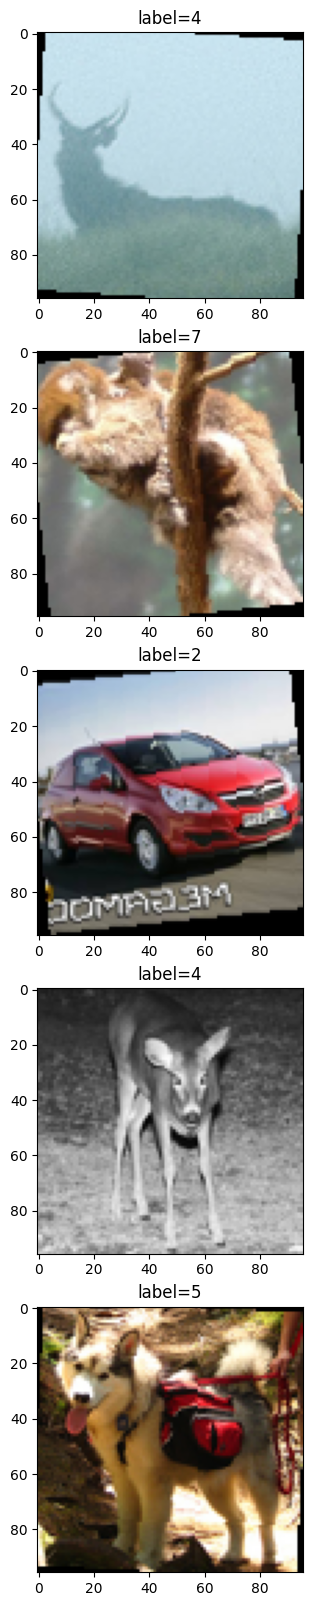

In [15]:
# visulaize images from the trainloader
visualize_dataloader(trainloader, class_names)

In [ ]:
# visulaize images from the valloader
visualize_dataloader(valloader, class_names)

In [ ]:
# visulaize images from the testloader
visualize_dataloader(testloader, class_names)

<div class="alert alert-block alert-info">

## 1.3 Design the CNN and Lightning Modules <a class="anchor" id="t1_3"></a>

You will design your CNN architecture using torch.nn module inside the *init* function. Then you will use the *forward* function to set the forward pass logic. The model architecture needs to contain the following:
    
| Layer Name |    Layer Type     | channels | kernel size | stride | padding |  Input size  |  Output size |
|:----------:|:---------------:  |----------|-------------|--------|---------|:------------:|:------------:|
|    conv1   |      Conv2D       | 16       | (3,3)       | 1      | 1       |  (3, 96, 96) | (16, 96, 96) |
| relu       |       ReLU        |          |             |        |         | (16, 96, 96) | (16, 96, 96) |
|    pool    |     MaxPool2d     |          | (2,2)       | 2      | 0       | (16, 96, 96) | (16, 48, 48) |            
|    conv2   |      Conv2D       | 32       | (3,3)       | 1      | 1       | (16, 48, 48) | (32, 48, 48) |    
| relu       |       ReLU        |          |             |        |         | (32, 48, 48) | (32, 48, 48) |
|    pool    |     MaxPool2d     |          | (2,2)       | 2      | 0       | (32, 48, 48) | (32, 24, 24) |              
|    conv3   |      Conv2D       | 64       | (3,3)       | 1      | 1       | (32, 24, 24) | (64, 24, 24) |   
| relu       |       ReLU        |          |             |        |         | (64, 24, 24) | (64, 24, 24) |
|    pool    |     MaxPool2d     |          | (2,2)       | 2      | 0       | (64, 24, 24) | (64, 12, 12) |             
| gap        | AdaptiveAvgPool2d |          |             |        |         | (64, 12, 12) | (64, 12, 12) |
| relu       |       ReLU        |          |             |        |         | (64, 12, 12) | (64, 12, 12) |
| flatten    | Flatten           |          |             |        |         | (64, 12, 12) |    (9216)    |
| fc         | Linear            | 10       |             |        |         |  (9216)      |     (10)     |
   
Apart from the model design we will construct the following pytorch lightning modules.

- *training_step*: Define logic for training step
- *validation_step*: Define logic for validation step
- *test_step*: Define logic for test step
- *predict_step*: Define logic for inference/prediction step
- *configure_optimizers*: Configure optimizers and schedulers

Other hyperparameters:
- Use cross-entropy loss
- Use the ADAM optimizer with lr = 0.001
- Epochs = 50

_Notes:_

- `AdaptiveAvgPool2d` will automatically calculate the required parameters to achieve the output dimension so you only need to specify an output size (number of channels will be reflected automatically). More information can be found here: https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html

### Design the CNN

In [106]:
class MyCNN(pl.LightningModule):

    def __init__(self, num_classes):
        super().__init__()

        # You may or may not want to save the hyperparameters
        self.learning_rate = 0.001
        self.optimizer = "ADAM"
        self.save_hyperparameters()
        # Define Neural Network layers
        # Create the 1st Convolutional Layer:
        # Input channels: 3, Output channels: 16, Kernel size: 3x3, Stride: 1, Padding: 1
        self.conv1 = nn.Conv2d(3,16,(3,3),1,1)

        # Create the 2nd Convolutional Layer:
        # Input channels: 16, Output channels: 32, Kernel size: 3x3, Stride: 1, Padding: 1
        self.conv2 = nn.Conv2d(16, 32, (3,3), 1, 1)

        # Create the 3rd Convolutional Layer:
        # Input channels: 32, Output channels: 64, Kernel size: 3x3, Stride: 1, Padding: 1
        self.conv3 = nn.Conv2d(32, 64, (3,3), 1, 1)

        # Create ReLU Activation Layer
        self.relu = nn.ReLU()
        # Create a MaxPool layer with the required kernel size and stride
        self.maxPool = nn.MaxPool2d((2,2),2,0)
        # Create Global Adaptive Average Pooling Layers:
        # Use nn.AdaptiveAvgPool2d
        # GAP - Layer : Output size 12x12
        self.gap = nn.AdaptiveAvgPool2d((12,12))
        # Create Fully Connected Layers:
        # FC - Layer : Input size 64*12*12, Output size num_classes=10
        self.fc = nn.Linear(64*12*12,10)
        # Define loss function
        self.loss_fn = nn.CrossEntropyLoss()
        # Define metrics for Train, Val and Test
        self.train_accuracy = torchmetrics.Accuracy('multiclass',num_classes=num_classes)
        self.val_accuracy =torchmetrics.Accuracy('multiclass',num_classes=num_classes)
        self.test_accuracy = torchmetrics.Accuracy('multiclass',num_classes=num_classes)

    def forward(self, x):

        # Define Forward pass logic
        # Conv1 -> ReLU -> MaxPool2d
        hidden_1 = self.maxPool(self.relu(self.conv1(x)))

        # Conv2 -> ReLU -> MaxPool2d
        hidden_2 = self.maxPool(self.relu(self.conv2(hidden_1)))

        hidden_3 = self.maxPool(self.relu(self.conv3(hidden_2)))

        # AdaptiveAvgPool2d(12x12) -> ReLU
        hidden_4 = self.relu(self.gap(hidden_3))
        # Reshape the Tensor to 1 dimension so (Batch_size, everything else):
        flatten = hidden_4.view(hidden_4.shape[0],-1)
        # Apply the Fully Connected Layer (Output Layer):
        out = self.fc(flatten)
        # The final output x represents the predictions of the neural network.

        return out # Return the output

    def training_step(self, batch, batch_idx):
        # Define logic for training step
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)

        preds = logits.argmax(1)
        self.train_accuracy.update(preds, y)

        train_dict = {"train_loss": loss,
                      "train_acc": self.train_accuracy.compute(),
                      "epoch": self.current_epoch}

        self.log_dict(train_dict, prog_bar=True, on_step=False, on_epoch=True)


        return loss


    def validation_step(self, batch, batch_idx):
        # Define logic for validation step
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)

        preds = logits.argmax(1)
        self.val_accuracy.update(preds, y)

        val_dict = {"val_loss": loss,
                    "val_acc": self.val_accuracy.compute(),
                    "epoch": self.current_epoch}

        self.log_dict(val_dict, prog_bar=True, on_step=False, on_epoch=True)



    def test_step(self, batch, batch_idx):
        # Define logic for test step
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)

        preds = logits.argmax(1)
        self.test_accuracy.update(preds, y)

        test_dict = {"test_loss": loss,
                     "test_acc": self.test_accuracy.compute(),
                     "epoch": self.current_epoch}

        self.log_dict(test_dict, prog_bar=True, on_step=False, on_epoch=True)


    def predict_step(self, batch, batch_idx):
        x,y = batch
        pred = self.forward(x)
        return pred,y,x # Return predicted class, actual class, and input

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    ####################
    # DATA RELATED HOOKS
    ####################

    def train_dataloader(self):
        return trainloader

    def val_dataloader(self):
        return valloader

    def test_dataloader(self):
        return testloader

<div class="alert alert-block alert-info">

## 1.4 Train and Evaluate the CNN <a class="anchor" id="t1_4"></a>
    
 Here you will train the model that you have already constructed. To start with, you may visualzue the CNN to make sure that everything is in place. Then you will define a checkpoint callback function in order to save the weights of model at the best performing epoch. Finally you will train your model for a predefined number of epochs. Once trained, you may load the saved weights of the model and verify your model performance on the test set. Let's see whether you can achieve a test accuracy over 80%.

 _Note_: You can load the model checkpoint similar to how we loaded the CNN from lab 3. You need to define an object with the same class definition, then load in the weights via the dictionary. This way, once you have finalised your model in task 1, you do not need to re-train it in task 2 (as you will use the same model to perform analysis)

### Initialize the CNN

In [107]:
# Initialize the model by creating instance from Model class
task1_model = MyCNN(num_classes)

# Display a summary of the model's architecture
summary(task1_model.to('cuda'), (3, 96,96)) # delete .to('cuda') if not using cpu

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 96, 96]             448
              ReLU-2           [-1, 16, 96, 96]               0
         MaxPool2d-3           [-1, 16, 48, 48]               0
            Conv2d-4           [-1, 32, 48, 48]           4,640
              ReLU-5           [-1, 32, 48, 48]               0
         MaxPool2d-6           [-1, 32, 24, 24]               0
            Conv2d-7           [-1, 64, 24, 24]          18,496
              ReLU-8           [-1, 64, 24, 24]               0
         MaxPool2d-9           [-1, 64, 12, 12]               0
AdaptiveAvgPool2d-10           [-1, 64, 12, 12]               0
             ReLU-11           [-1, 64, 12, 12]               0
           Linear-12                   [-1, 10]          92,170
Total params: 115,754
Trainable params: 115,754
Non-trainable params: 0
-------------------------------

### Define progress bar and checkpoint callback functions to save the model at the best epoch

In [108]:
# Create a checkpoint callback function to save the best model based on validation accuracy
checkpoint_callback = ModelCheckpoint(
    monitor="val_acc",         # Monitor the validation accuracy for saving checkpoints
    save_top_k=1,              # Save the top 1 best model based on validation accuracy
    mode="max",                # Choose the mode 'max' to maximize the monitored metric (accuracy)
    every_n_epochs=1           # Save a checkpoint every epoch
)
ver_num = 0

### Train the CNN

In [109]:
# Define the trainer with specified configurations
ver_num+=1
task1_trainer = pl.Trainer(
    accelerator = "auto",
    devices = 1 if torch.cuda.is_available() else None,
    max_epochs = 50,
    callbacks = [TQDMProgressBar(refresh_rate=20), checkpoint_callback],
    logger = CSVLogger(save_dir="logs/task1",version=ver_num)
) # Call pl.Trainer and put in the relevant arguments

# Fit the model using the defined trainer
# You may comment this line if you do not wish to train the model but use a previous checkpoint
task1_trainer.fit(task1_model)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning_fabric/loggers/csv_logs.py:268: Experiment logs directory logs/task1/lightning_logs/version_1 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name           | Type               | Params | Mode 
---------------------------------------------------------------
0  | conv1          | Conv2d             | 448    | train
1  | conv2          | Conv2d             | 4.6 K  | train
2  | conv3          | Conv2d             | 18.5 K | train
3  | relu           | ReLU               | 0      | train
4  | maxPool       

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (40) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.



# Checkpoints and model's state_dict

In PyTorch, a model's state_dict is a Python dictionary object that contains the learnable parameters (model weights) and their associated values for a neural network model. It serves as a convenient way to save and load model weights, enabling model persistence and transferability across different sessions and tasks.

Once you have trained your CNN by running the above cell, you will notice a `/logs` folder appearing in your working directory. Within this folder you will find model checkpoints that contains the model's state_dict. Also it will contain a csv file which contains train/val loss/accuracy information. Explore this folder on your own and learn how pytorch lightning saves this information.
    
Also note how different versions of your implementations are saved. This feature in pytorch lightning enables you to access information of previously trained models easily. You can easily know the version of the current training run by observing the progress bar during training as below:

<img src="https://github.com/daniel-kaz/ece4179-lab4/blob/master/images/progress-bar.png?raw=1"/>
    
You might have to access that specific version in your file directory to obtain the name of the checkpoint in order to access the relevant state_dict for your CNN as the examples given below:
    
`checkpoint_task1 = torch.load('logs/task1/lightning_logs/version_18/checkpoints/epoch=41-step=1680.ckpt')`

### Load model's state_dict

When you load the model's state dictionary, you have to adjust the version of the model that you want to load. The one below is just an example

In [111]:
checkpoint_task1 = torch.load(f'logs/task1/lightning_logs/version_{ver_num}/checkpoints/epoch=49-step=2000.ckpt')
print(checkpoint_task1.keys()) # print out the keys of the checkpoint to see what information it contains

dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'loops', 'callbacks', 'optimizer_states', 'lr_schedulers', 'hparams_name', 'hyper_parameters'])


<ipython-input-111-4f20bc21052a>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_task1 = torch.load(f'logs/task1/lightning_logs/version_{ver_num}/checkpoints/epo

In [112]:
state_dict_task1 = checkpoint_task1['state_dict']
task1_model.load_state_dict(state_dict_task1)

# If your state_dic is loaded successfully, you will get a message like below:
# "<All keys matched successfully>"

<All keys matched successfully>

### Test the CNN

In [113]:
# Now call test from trainer
task1_trainer.test(task1_model)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           epoch           │           50.0            │
│         test_acc          │    0.6030012369155884     │
│         test_loss         │    1.5543980598449707     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.5543980598449707,
  'test_acc': 0.6030012369155884,
  'epoch': 50.0}]

If your implementation is correct, you should obtain a printed output similar to this:

Note: You may not get exactly the same numbers

[{'test_loss': 1.5672231912612915, 'test_acc': 0.6288571357727051}]

<div class="alert alert-block alert-info">

## 1.5 Visualize training and validation loss/accuracy <a class="anchor" id="t1_5"></a>

The PyTorch-Lightning module has its own built-in methods to log values. These log files can be then used to visualize experimental results. You can use python plotting libraries such as matplotlib. You can read the logs by using the pandas library (pd.read_csv) as the example given below: (Make sure to access the correct version number)

`metrics_task_1 = pd.read_csv("logs/task1/lightning_logs/version_18/metrics.csv")`

Using those logs, generate two plots.
    
1. train and validation losses against epoch.
2. train and validation accuracies against epoch.
    
Note: Visualizing the loss and accuracy curves will give you an understanding of whether your model has been trained/tested properly. If there are any strange behaviours in your loss and accuracy curves, it means either there may have been a mistake in your code or your implementation could be further improved. Based on your observations, you may want to go back and rectify all the above steps until you obtain well-behaved loss and accuracy curves.

### Read logs

In [136]:
# Read the metrics from the CSV file from the relevant version path
metrics_task_1 = pd.read_csv(f"logs/task1/lightning_logs/version_{ver_num}/metrics.csv")

# Set the "epoch" column as the index for easier data manipulation
metrics_task_1.set_index("epoch", inplace=True)

# Group the metrics by epoch and sum them while dropping the "step" column
metrics_task_1 = metrics_task_1.groupby(level=0).sum().drop("step", axis=1)

### Plot train and validation losses against epoch

epoch
0.0     1.628407
1.0     1.537253
2.0     1.664870
3.0     1.418321
4.0     1.454649
5.0     1.341047
6.0     1.279352
7.0     1.302445
8.0     1.404305
9.0     1.287329
10.0    1.189175
11.0    1.196646
12.0    1.219663
13.0    1.177283
14.0    1.163848
15.0    1.229997
16.0    1.233230
17.0    1.231010
18.0    1.206943
19.0    1.320314
20.0    1.220103
21.0    1.327892
22.0    1.283655
23.0    1.266114
24.0    1.316602
25.0    1.250659
26.0    1.300159
27.0    1.269995
28.0    1.307476
29.0    1.400744
30.0    1.276763
31.0    1.361523
32.0    1.317963
33.0    1.293242
34.0    1.326716
35.0    1.401032
36.0    1.359229
37.0    1.387721
38.0    1.386948
39.0    1.387045
40.0    1.399683
41.0    1.435887
42.0    1.468957
43.0    1.419923
44.0    1.450299
45.0    1.500681
46.0    1.471584
47.0    1.448736
48.0    1.448944
49.0    1.531813
50.0    0.000000
Name: val_loss, dtype: float64


Text(0.5, 1.0, 'Training and Validation Losses Against Epoch; Daniel Kazakevich, 33155542')

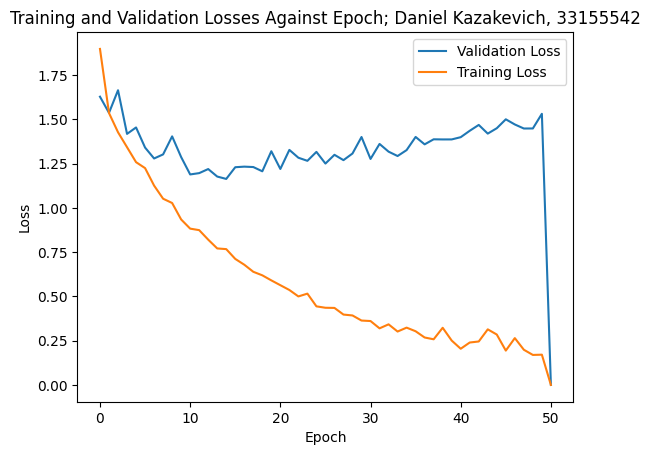

In [137]:
# Create a figure with all the appropriate labels/titles etc.
print(metrics_task_1["val_loss"])
plt.plot(metrics_task_1["val_loss"],label="Validation Loss")
plt.plot(metrics_task_1["train_loss"],label="Training Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Losses Against Epoch; Daniel Kazakevich, 33155542")


### Plot train and validation accuracies against epoch

Text(0.5, 1.0, 'Training and Validation Accuracies Against Epoch; Daniel Kazakevich, 33155542')

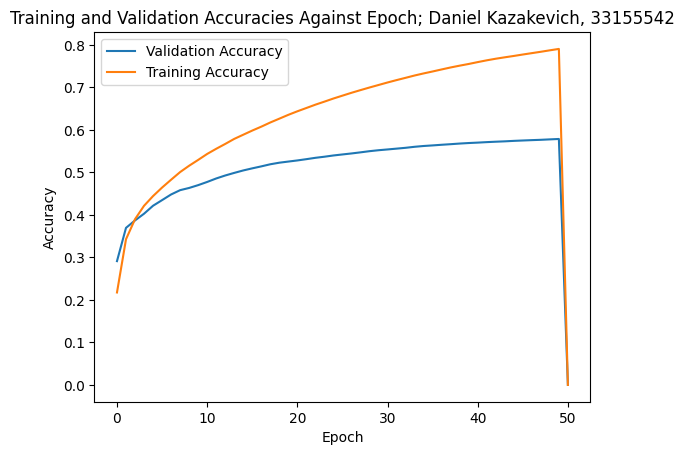

In [138]:
# Create a figure with all the appropriate labels/titles etc.
plt.plot(metrics_task_1["val_acc"],label="Validation Accuracy")
plt.plot(metrics_task_1["train_acc"],label="Training Accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracies Against Epoch; Daniel Kazakevich, 33155542")

<div class="alert alert-block alert-success">

## Discussion Questions <a class="anchor" id="t1_6"></a>
    
#### What is the purpose of saving the model checkpoint based on validation accuracy instead of training accuracy?
    
    
Answer:

    
#### Comment on your train / val loss plots and train / val accuracy plots
   
Answer:


$\;$

<div class="alert alert-block alert-info">

# Task 2 - Visualization and Analysis of Results <a class="anchor" id="task_2"></a>

Now that you have successfully trained a CNN to classify STL-10 data, you will visualize the results in order to see how well your trained model performs in class predictions. You will:

- Visualize some predictions
- Investigate which images the model shows high and low confidence.  
- Generate a confusion matrix and interpret the results
- Visualize some intermediate feature maps from your model and see how the convolution filters capture the information within the model.
- Understand which regions of the image are more important for the classification by applying saliency maps.

In [139]:
# Generate predictions using the trained model and the test data loader
# Note: Do not do anything to the variable 'predictions' you will reuse it
predictions = task1_trainer.predict(task1_model, testloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

<div class="alert alert-block alert-info">

## 2.1 Visualizing predictions <a class="anchor" id="t2_1"></a>

In this task, we want you to plot out 5 input images of the test set along with their respective predicted and ground-truth labels so that we can compare the predictions with the actual labels.

In [ ]:
# Extract predictions, labels, and inputs from the predictions result

???

<div class="alert alert-block alert-info">

## 2.2 Top Classified/Misclassified Images <a class="anchor" id="t2_2"></a>


In this task, we find the top 5 correctly classified and top 5 misclassified images for each of the classes from the test set and visualize them.

- Top 5 correctly  classified - for e.g. take the 'airplane' class. First, find the test images that that were correctly predicted as 'airplane'. Out of those images, find out the predctions that got highest softmax scores and visualize them. Do this for all classes (you might want to use a for loop for this).
- Top 5 Misclassified - for e.g. take the 'airplane' class. First, find the test images which were airplanes but were wrongly predicted as a different class. Out of those images, find out the 5 predictions that got highest softmax scores for the wrong class and visualize them. Do this for all classes (you might want to use a for loop for this as well).    
    
In total, you have 10 classes, and 5 top correctly classified and 5 top misclassified images for each class, hence you will have $10* (5+5)= 100$ images altogether. On top of each image, display its label, prediction, as well the the top softmax score as a percentage.
    
An example of an expected output for the Top Classified and Top Missclassifed images for the 'car' and 'dog' class are shown below:  
    
<img src="https://github.com/daniel-kaz/ece4179-lab4/blob/master/images/top-classified-demo.PNG?raw=1" />

<img src="https://github.com/daniel-kaz/ece4179-lab4/blob/master/images/top-mis-classified-demo.PNG?raw=1" />

### Get predictions for the test set for later use

In [ ]:
## These are the predictions, actual labels, and original images from the test set. You will use this for the tasks below during the analysis process.


# Concatenate the predictions from multiple batches
test_outputs = torch.cat([prediction[0] for prediction in predictions], dim=0)  # Concatenate model outputs
test_labels = torch.cat([prediction[1] for prediction in predictions], dim=0)  # Concatenate true labels
test_inputs = torch.cat([prediction[2] for prediction in predictions], dim=0)  # Concatenate input images

# Determine the predicted labels by selecting the class with the highest probability
test_preds = ????  # Find the index of the maximum probability along the classes (predicted labels)

### Top Classified

Complete your plots here for the top 5 correctly classified images from each class.
Make sure you put in the predicted and actual labels for each image.

In [ ]:
# Loop through each class (category)
for c in range(num_classes):

    ???

### Top Misclassified

Complete your plots here for the top 5 misclassified images from each class.
Make sure you put in the predicted and actual labels for each image.

In [ ]:
# Loop through each class (category)
for c in range(num_classes):

    ???

<div class="alert alert-block alert-info">

## 2.3 Confusion Matrix <a class="anchor" id="t2_3"></a>

### Introduction to Confusion matrix

Now let's do something new!

You will be generating a confusion matrix. For a two-class classification, the valued in a confusion matrix is defined as recall, precision values based on confusion matrix outcomes. See the following table for a two-class confusion matrix (in our case, we will have 10 classes):

<center><img src="https://miro.medium.com/v2/resize:fit:1100/format:webp/1*uR09zTlPgIj5PvMYJZScVg.png" width="600" height="300" /></center>


Now, what is a confusion matrix? A confusion matrix is a fundamental tool in the field of machine learning used to assess the performance of a classification model. It provides a comprehensive tabular representation of the model's predictions by categorizing them into four key outcomes: true positives, true negatives, false positives, and false negatives.
    
True positives indicate the instances where the model correctly predicted a positive class, while true negatives represent correct predictions of the negative class. False positives occur when the model wrongly predicts a positive class as negative, and false negatives signify incorrect predictions of the negative class as positive.
    
By visually summarizing these prediction results, the confusion matrix enables you to derive various performance metrics, such as accuracy, precision, recall, and F1-score, which offer deeper insights into the model's strengths and weaknesses across different classes, aiding in the evaluation and refinement of its predictive capabilities.

In this task, we will visualize the ability of the network to classify the images in the test set by using a slightly more complex confusion matrix, ie, a confusino matrix for multiclass classification. You may choose to construct the matrix from scratch by yourself, or use the existing [ConfusionMatrix](https://lightning.ai/docs/torchmetrics/stable/classification/confusion_matrix.html) class in pytorch lightning.

Make sure to correctly label the x and y-axes to display the class names. Apply a **proportional** output for the confusion matrix (ie. all the cells should be standardised between 0 and 1)

In [ ]:
# Create a ConfusionMatrix instance for multiclass classification with 'num_classes'
#  You may use the "confusion_matrix" from the sklearn library
???

<div class="alert alert-block alert-warning">

## Feature Maps

Intermediate feature maps in CNN represent the hierarchical transformations of input data as it passes through the network's layers. These feature maps capture increasingly abstract and complex features, gradually transitioning from low-level features like edges and textures in the early layers to high-level concepts and object representations in deeper layers. By visualizing these intermediate feature maps, we can gain insights into how the network is learning and extracting relevant information from the input data, helping us in the understanding and improvement of CNN architectures.

<div class="alert alert-block alert-info">

## 2.4 Visualize Feature Maps <a class="anchor" id="t2_4"></a>

In this task we will visualize the feature maps of an image at different stages of the trained CNN. Select a __correctly__ predicted image from the test set and pass it through the CNN.
    
1. Observe the output after 1st relu layer (16 feature maps of size 96x96)
2. Observe the output after 2nd relu layer (32 feature maps of size 48x48)
3. Observe the output after 3rd relu layer (64 feature maps of size 24x24)

Observe the differences between the feature maps at different levels.
    

We pass through an original image here

<img src="https://github.com/daniel-kaz/ece4179-lab4/blob/master/images/feature_map_sample_original.PNG?raw=1" />

An example of an expected output for the feature maps generated from the 1st relu layer are shown below (based on the image above):  

<img src="https://github.com/daniel-kaz/ece4179-lab4/blob/master/images/feature_map_sample.png?raw=1" />

In [ ]:
# Find indices of correctly classified test samples
???

# Select a random index from the correctly classified samples
???

# Retrieve the image, true label, model output, predicted label for the selected index
???

# Create a plot for displaying the selected image
???

In [ ]:
# You will be defining the visualize_features function here
# Where you will visualize the features at different convolutional layers
# To see what "features" is as an input, we recommend looking at the comments in the next code cell
# so that you can understand what the shape of the feature map is after passing the image through the convolutional layers and activation functions

def visualize_features(features):
    # Determine the number of feature maps
    # Determine the maximum and minimum values within each feature map so you can normalize the plot of the features according to these values
    num_fmaps = features.shape[0] # Number of feature maps in each layer
    num_cols = 8 # We always have divisible powers of 8 for the number of channels in the conv layers
    num_rows = ???
    fmax = ??? # Max values of features
    fmin = ??? # Min values of features

    # Create the figures of the feature maps
    ???

In [ ]:
# Compute the feature maps for the input image using the first relu layer
# You can do this by only passing your image through the first conv1 and then relu layer manually
# For example, if the conv1 in my first layer of the class was called my_cnn.conv1(), then I can pass
# the image through the conv1 layer by my_cnn.conv1(image) then passing that through a relu layer
# We can then plot the output from that feature map
???

# Visualize the feature maps using the 'visualize_features' function
???

In [ ]:
# Compute the feature maps for the input image using the second conv and relu layer (after passing it through earlier layers)
# You can reuse the feature map from the previous code cell to do this

???

# Visualize the feature maps using the 'visualize_features' function
???

In [ ]:
# Compute the feature maps for the input image using the third conv and relu layer (after passing it through earlier layers)
# You can reuse the feature map from the previous code cell to do this
???

# Visualize the feature maps using the 'visualize_features' function
???

<div class="alert alert-block alert-warning">

## Saliency Maps

A saliency map is a visual representation that highlights the most important regions within an input image that significantly influence the decision of a Convolutional Neural Network (CNN). It provides insights into the features and areas of an image that contribute the most to the network's output, helping in understanding model decisions and feature selection.

<div class="alert alert-block alert-info">

## 2.5 Visualize Saliency Maps  <a class="anchor" id="t2_5"></a>
    
One of the easiest methods to generate a saliency map of a CNN predictions is to find the the derivative of the maximum output with respect to the input image. This will tell us which pixels of the image are most sensitive towards the prediction. Such a derivative map can be obtained via following steps.
    
1. Select a correctly predicted image from the test set
    
2. Enable the `grad_fun` of this image tensor using `.requires_grad = True` (This is will enable us to compute gradients of the image)
    
3. Pass the image through the CNN.

4. At the output, find the maximum score (out of the 10 values).
    
5. Perform a backpropagation with respect to the maximum output score using `.backward()`.

6. Find the absolute gradients of the input image tensor using `.grad.data.abs()`.
    
7. This will give you a map with three channels. Let's reduce is to a single channel by finding the maximum value across all channels for each pixel.

Voila! Your Saliency Map! Visualize it alongside with the input image.
    
An example of an expected output for the saliency map is shown below:  
    
<img src="https://github.com/daniel-kaz/ece4179-lab4/blob/master/images/saliency_map_sample.PNG?raw=1" />

In [ ]:
# Find indices of correctly classified test samples
???

# Select a random index from the correctly classified samples
???

# Retrieve the input image, true label, model output, predicted label for the selected index
???

# Add a batch dimension to the input image (via .unsqueeze()) and set requires_grad to True for saliency analysis
image = image.unsqueeze(0)
image.requires_grad = True

# Compute the scores and gradients for the input image
# To compute the scores, do a forward pass of the image and then take the argmax
# Use this index to extract the score_max value from "scores"
# Then perform a backward step so that it backpropagates the gradient
scores = ???
score_max_index = ???
score_max = scores[0, score_max_index]
??? # Do the backward step here for the gradient calculation

# Calculate the saliency map by finding the maximum absolute gradient values across channels
# You can use .abs() and torch.max()
???

# Create a subplot to display the original image and saliency map side by side
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

# Display the original image with proper unnormalization
# Do this in the first subplot
???

# Display the saliency map
# Do this in the second subplot
???

# Show the original image and saliency map side by side
plt.show()

<div class="alert alert-block alert-success">

## Discussion <a class="anchor" id="t2_6"></a>
    
#### What do you notice about the top correctly classified and misclassified images? Explain your reasoning.
    
Answer:
    
  
#### Based on the confusion matrix, what can you say about this model's ability to predict certain classes?
    
Answer:
    

#### What are the implications behind stacking CNN layers? Discuss with respect to the generated feature maps.
    
Answer:
    
     
#### Test your code for saliency maps on several correctly classified images of the test set. Discuss and interpret the resulting saliency maps.
    
Answer:

<div class="alert alert-block alert-danger">

#### This is the end of Notebook I. Now move on to the Notebook II in order to apply the knowledge you have gained on CNNs to solve a practical problem.